<a href="https://colab.research.google.com/github/dl-ub-summer-school/2021/blob/main/Seminar_3_MLP_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep learning UB 2021 
## Семинар 3 -- Softmax classification/multiclass classification 

## Математикийн хэлээр 

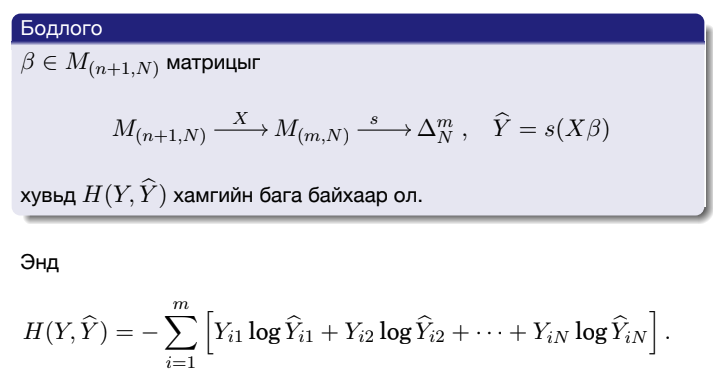

## Нэг юм ангилах, олон ангиудад хувааж ангилах / binary vs multi-class classification 

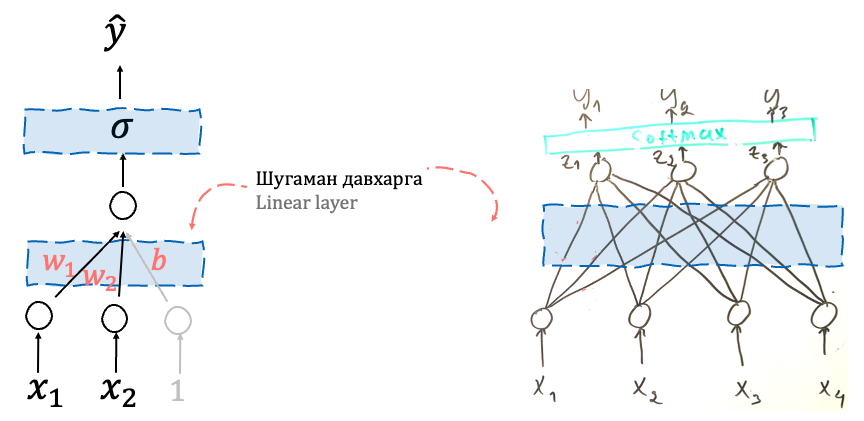

---
---
# За жинxнээсээ семинараа эхлэе! 



In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
training_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
validation_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
print(training_data)
print(validation_data)
print(training_data.data.size())

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()
torch.Size([60000, 28, 28])


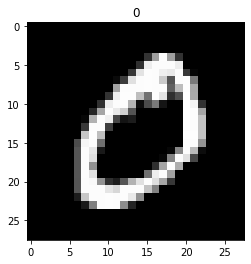

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  51, 159, 253, 159,  50,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  48, 238, 252, 252, 252, 237,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  54, 227, 253, 252, 239, 2

In [5]:
plt.imshow(training_data.data[1], cmap='gray')
plt.title('%i' % training_data.targets[1])
plt.show()
torch.set_printoptions(linewidth=200)
training_data.data[1]

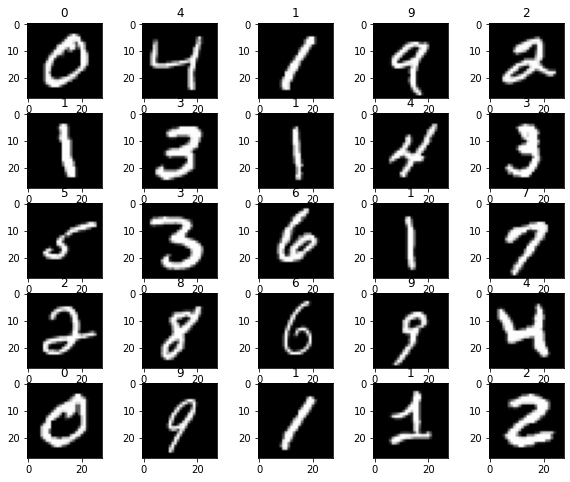

In [6]:
figure = plt.figure(figsize=(10, 8))
for i in range(1, 26):
  img, label = training_data[i]
  figure.add_subplot(5, 5, i)
  plt.title(label)
  plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [7]:
idxs = list(range(1000))
batch_size = 50 
training_data_loader = torch.utils.data.DataLoader(training_data, 
                                          batch_size=batch_size, 
                                          # shuffle=True, 
                                          num_workers=1, 
                                          sampler=SubsetRandomSampler(idxs)
                                          )

val_idxs = list(range(1000))
validation_data_loader = torch.utils.data.DataLoader(validation_data, 
                                          batch_size=batch_size, 
                                          # shuffle=True, 
                                          num_workers=1,
                                          sampler=SubsetRandomSampler(idxs))

training_data_loader, validation_data_loader

(<torch.utils.data.dataloader.DataLoader at 0x7faee2eaeb50>,
 <torch.utils.data.dataloader.DataLoader at 0x7faee2eae950>)

In [8]:
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(28*28, 10)

  def forward(self, x):
    y_pred = self.linear(x)
    # y_pred = softmax(y_pred)
    return y_pred

In [9]:
model = MLP()
model

MLP(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)

In [10]:
# Загвараа сургая
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
epoch = 100
losses = list()
corrects_history = list()

CEL = nn.CrossEntropyLoss()


for i in range(epoch):
  training_corrects = 0.0 
  training_loss = 0.0 

  for X, y in training_data_loader:
    X = X.view(X.shape[0], -1)

    y_pred = model.forward(X)

    S = CEL(y_pred, y)

    optimizer.zero_grad()
    S.backward()
    optimizer.step()

    losses.append(S.item())
    max_vals, max_idxs = torch.max(y_pred, 1)
    training_corrects += torch.sum(max_idxs == y.data)
    training_loss += S.item()

  epoch_loss = training_loss / len(training_data_loader)
  epoch_acc = 100.0 * training_corrects / ( len(training_data_loader) * batch_size )

  if i % 10 == 0:
    print("Epoch: ", i+1)
    print("Training loss: {:.4f}, Training acc: {:.4f}". format(epoch_loss, epoch_acc))

Epoch:  1
Training loss: 2.1990, Training acc: 31.8000
Epoch:  11
Training loss: 1.1155, Training acc: 81.4000
Epoch:  21
Training loss: 0.8130, Training acc: 84.3000
Epoch:  31
Training loss: 0.6764, Training acc: 85.9000
Epoch:  41
Training loss: 0.5958, Training acc: 87.3000
Epoch:  51
Training loss: 0.5410, Training acc: 88.1000
Epoch:  61
Training loss: 0.5005, Training acc: 89.3000
Epoch:  71
Training loss: 0.4688, Training acc: 89.8000
Epoch:  81
Training loss: 0.4431, Training acc: 90.1000
Epoch:  91
Training loss: 0.4215, Training acc: 90.5000


## MLP

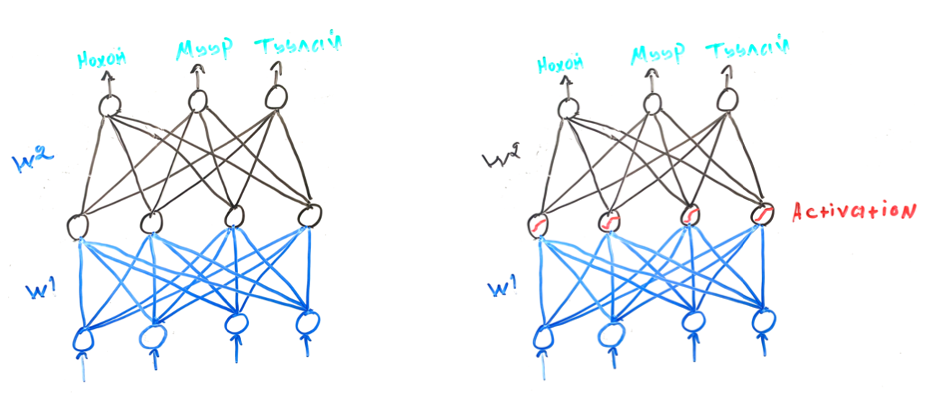

In [11]:
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(28*28, 512)
    self.linear2 = nn.Linear(512, 512)
    self.linear3 = nn.Linear(512, 10)

  def forward(self, x):
    x = self.linear1(x)
    x = F.relu(x)
    x = self.linear2(x)
    x = F.relu(x)
    x = self.linear3(x)
    return x

In [12]:
model = MLP()
model

MLP(
  (linear1): Linear(in_features=784, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=10, bias=True)
)

In [13]:
# Загвараа сургая
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
epoch = 200
losses = list()
val_losses = list()

epoch_loss_history = list()
epoch_acc_history = list()

epoch_val_loss_history = list()
epoch_val_acc_history = list()

CEL = nn.CrossEntropyLoss()


for i in range(epoch):
  training_corrects = 0.0 
  training_loss = 0.0 

  val_corrects = 0.0 
  val_loss = 0.0 

  # Training
  for X, y in training_data_loader:

    X = X.view(X.shape[0], -1)
    y_pred = model.forward(X)
    S = CEL(y_pred, y)
    optimizer.zero_grad()
    S.backward()
    optimizer.step()

    losses.append(S.item())
    max_vals, max_idxs = torch.max(y_pred, 1)
    training_corrects += torch.sum(max_idxs == y.data)
    training_loss += S.item()

  epoch_loss = training_loss / len(training_data_loader)
  epoch_acc = 100.0 * training_corrects / ( len(training_data_loader) * batch_size )

  epoch_loss_history.append(epoch_loss)
  epoch_acc_history.append(epoch_acc)

  # Validation
  with torch.no_grad(): # Context manager. No grad will be calculated.
    for X, y in validation_data_loader:

      X = X.view(X.shape[0], -1)
      y_pred = model.forward(X)
      S = CEL(y_pred, y)

      val_losses.append(S.item())
      max_vals, max_idxs = torch.max(y_pred, 1)
      val_corrects += torch.sum(max_idxs == y.data)
      val_loss += S.item()

  epoch_val_loss = val_loss / len(validation_data_loader)
  epoch_val_acc = 100.0 * val_corrects / ( len(validation_data_loader) * batch_size )

  epoch_val_loss_history.append(epoch_val_loss)
  epoch_val_acc_history.append(epoch_val_acc)

  if i % 10 == 0:
    print("Epoch: ", i+1)
    print("Training loss: {:.4f}, training_acc: {:.4f}". format(epoch_loss, epoch_acc))
    print("Val_loss: {:.4f}, val_acc: {:.4f}". format(epoch_val_loss, epoch_val_acc))

Epoch:  1
Training loss: 2.2926, training_acc: 9.7000
Val_loss: 2.2900, val_acc: 11.4000
Epoch:  11
Training loss: 2.1492, training_acc: 61.0000
Val_loss: 2.1764, val_acc: 53.3000
Epoch:  21
Training loss: 1.7191, training_acc: 66.6000
Val_loss: 1.8055, val_acc: 60.9000
Epoch:  31
Training loss: 1.0444, training_acc: 79.6000
Val_loss: 1.1991, val_acc: 70.8000
Epoch:  41
Training loss: 0.6952, training_acc: 85.0000
Val_loss: 0.8769, val_acc: 75.4000
Epoch:  51
Training loss: 0.5302, training_acc: 86.6000
Val_loss: 0.7272, val_acc: 78.0000
Epoch:  61
Training loss: 0.4344, training_acc: 88.6000
Val_loss: 0.6488, val_acc: 79.4000
Epoch:  71
Training loss: 0.3712, training_acc: 90.1000
Val_loss: 0.5932, val_acc: 80.7000
Epoch:  81
Training loss: 0.3259, training_acc: 91.1000
Val_loss: 0.5604, val_acc: 81.7000
Epoch:  91
Training loss: 0.2885, training_acc: 92.4000
Val_loss: 0.5373, val_acc: 82.4000
Epoch:  101
Training loss: 0.2584, training_acc: 93.2000
Val_loss: 0.5181, val_acc: 82.9000


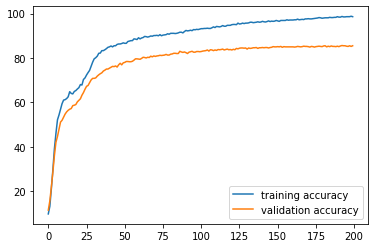

In [14]:
plt.plot(epoch_acc_history, label='training accuracy')
plt.plot(epoch_val_acc_history, label='validation accuracy')
plt.legend()

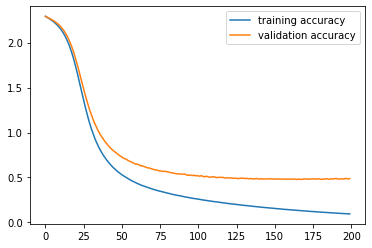

In [15]:
plt.plot(epoch_loss_history, label='training accuracy')
plt.plot(epoch_val_loss_history, label='validation accuracy')
plt.legend()

## Dropout
### Дээрх жишээ шиг хэтэрхий over-fit болоод байгаа үед сургаж буй параметруудаа regularize хийх нэг арга. 

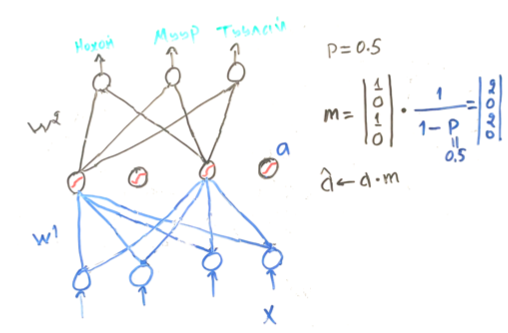

In [16]:
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(28*28, 512)
    self.linear2 = nn.Linear(512, 512)
    self.linear3 = nn.Linear(512, 10)
    self.dropout = nn.Dropout(0.4)

  def forward(self, x):
    x = self.linear1(x)
    x = F.relu(x)
    x = self.dropout(x)
    x = self.linear2(x)
    x = F.relu(x)
    x = self.dropout(x)
    x = self.linear3(x)
    
    return x

In [17]:
model = MLP()
model

MLP(
  (linear1): Linear(in_features=784, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

In [18]:
# Загвараа сургая
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
epoch = 200
losses = list()
val_losses = list()

epoch_loss_history = list()
epoch_acc_history = list()

epoch_val_loss_history = list()
epoch_val_acc_history = list()

CEL = nn.CrossEntropyLoss()


for i in range(epoch):
  training_corrects = 0.0 
  training_loss = 0.0 

  val_corrects = 0.0 
  val_loss = 0.0 

  # Training
  for X, y in training_data_loader:

    X = X.view(X.shape[0], -1)
    y_pred = model.forward(X)
    S = CEL(y_pred, y)
    optimizer.zero_grad()
    S.backward()
    optimizer.step()

    losses.append(S.item())
    max_vals, max_idxs = torch.max(y_pred, 1)
    training_corrects += torch.sum(max_idxs == y.data)
    training_loss += S.item()

  epoch_loss = training_loss / len(training_data_loader)
  epoch_acc = 100.0 * training_corrects / ( len(training_data_loader) * batch_size )

  epoch_loss_history.append(epoch_loss)
  epoch_acc_history.append(epoch_acc)

  # Validation
  with torch.no_grad(): # Context manager. No grad will be calculated.
    for X, y in validation_data_loader:

      X = X.view(X.shape[0], -1)
      y_pred = model.forward(X)
      S = CEL(y_pred, y)

      val_losses.append(S.item())
      max_vals, max_idxs = torch.max(y_pred, 1)
      val_corrects += torch.sum(max_idxs == y.data)
      val_loss += S.item()

  epoch_val_loss = val_loss / len(validation_data_loader)
  epoch_val_acc = 100.0 * val_corrects / ( len(validation_data_loader) * batch_size )

  epoch_val_loss_history.append(epoch_val_loss)
  epoch_val_acc_history.append(epoch_val_acc)

  if i % 10 == 0:
    print("Epoch: ", i+1)
    print("Training loss: {:.4f}, training_acc: {:.4f}". format(epoch_loss, epoch_acc))
    print("Val_loss: {:.4f}, val_acc: {:.4f}". format(epoch_val_loss, epoch_val_acc))

Epoch:  1
Training loss: 2.2995, training_acc: 13.7000
Val_loss: 2.2963, val_acc: 13.8000
Epoch:  11
Training loss: 2.1875, training_acc: 49.2000
Val_loss: 2.2019, val_acc: 44.4000
Epoch:  21
Training loss: 1.8702, training_acc: 61.2000
Val_loss: 1.9262, val_acc: 57.2000
Epoch:  31
Training loss: 1.2505, training_acc: 71.4000
Val_loss: 1.3757, val_acc: 63.0000
Epoch:  41
Training loss: 0.8722, training_acc: 78.3000
Val_loss: 1.0420, val_acc: 68.5000
Epoch:  51
Training loss: 0.6740, training_acc: 82.4000
Val_loss: 0.8785, val_acc: 71.0000
Epoch:  61
Training loss: 0.5686, training_acc: 83.9000
Val_loss: 0.7981, val_acc: 74.7000
Epoch:  71
Training loss: 0.4866, training_acc: 86.0000
Val_loss: 0.7353, val_acc: 74.6000
Epoch:  81
Training loss: 0.4315, training_acc: 88.7000
Val_loss: 0.6802, val_acc: 76.8000
Epoch:  91
Training loss: 0.3984, training_acc: 88.4000
Val_loss: 0.6718, val_acc: 77.9000
Epoch:  101
Training loss: 0.3674, training_acc: 88.5000
Val_loss: 0.6211, val_acc: 79.4000

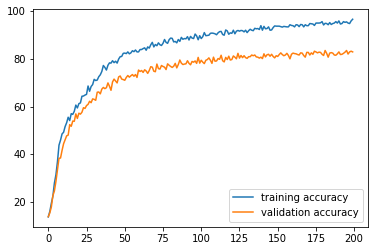

In [19]:
plt.plot(epoch_acc_history, label='training accuracy')
plt.plot(epoch_val_acc_history, label='validation accuracy')
plt.legend()

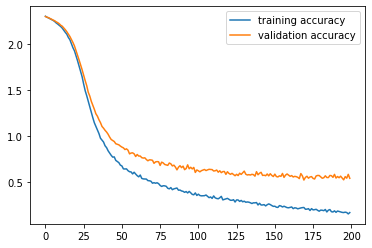

In [20]:
plt.plot(epoch_loss_history, label='training accuracy')
plt.plot(epoch_val_loss_history, label='validation accuracy')
plt.legend()